# Histogramm-Erstellung

In [25]:
#Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [26]:
def create_histogram(image_path):
    # Bild einlesen und in numpy-array umwandeln
    image = Image.open(image_path)
    image_array = np.array(image, dtype='uint8')

    # Länge von Histogramm Array wählen (8 bit, also 2^8 = 256)
    histogram = np.zeros(2**8)

    # Maße des Bildes bestimmen
    height, width = image_array.shape

    # Schleife über jeden Pixel und je nach Wert vom Pixel den entsprechende Anzahl im Histogramm erhöhen
    for x in range(width):
        for y in range(height):
            pixel_value = image_array[y][x]
            histogram[pixel_value] += 1
    
    return histogram

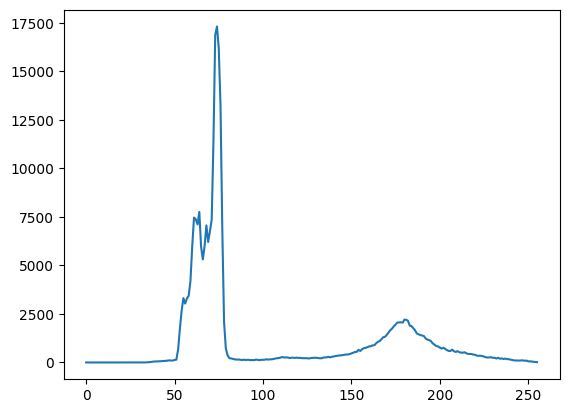

In [27]:
plt.plot(create_histogram("coins.bmp"))

#  Kostrastverstärkung durch Histogrammausgleich

In [28]:
def contrast_enhancement(image_path):
    
    # Bild einlesen und in numpy-array umwandeln
    image = Image.open(image_path)
    image_array = np.array(image, dtype='uint8')
    
    # Maße des Bildes bestimmen
    height, width = image_array.shape

    # Histogramm berechnen
    histogram = create_histogram(image_path)
    histogram_len = len(histogram)

    # Schritt 1: Berechnung des akkumulierten Histogramms
    accumulated_histogram = np.zeros_like(histogram, dtype='int')
    for i in range(histogram_len):
        for j in range(i+1):
            accumulated_histogram[i] = accumulated_histogram[i] + histogram[j]

    # Schritt 2: Normierung des akkumulierten Histogramms (Wertebereich 0...1)
    g_max = len(accumulated_histogram) - 1
    g_min = 0
    normed_histogram = np.zeros_like(histogram)
    for g in range(histogram_len):
        normed_histogram[g] = (accumulated_histogram[g] - histogram[g_min]) / (accumulated_histogram[g_max] - histogram[g_min])
    
    # Schritt 3: Transformation der Quellgrauwerte auf die Zielgrauwerte
    enhanced_image_array = np.zeros_like(image_array)

    for x in range(width):
        for y in range(height):
            pixel_value = image_array[y][x]
            enhanced_image_array[y][x] = normed_histogram[pixel_value] * g_max

    return enhanced_image_array

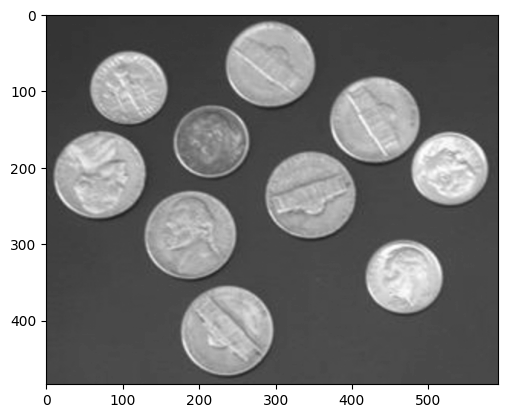

In [29]:
image = Image.open("coins.bmp")
image_array = np.array(image, dtype='int')
plt.imshow(image_array, cmap='gray', vmin=0, vmax=256)

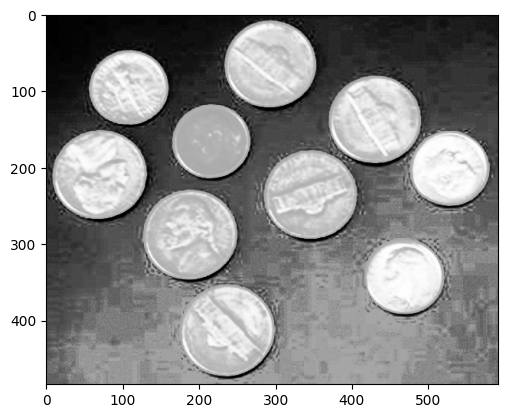

In [30]:
plt.imshow(contrast_enhancement("coins.bmp"), cmap='gray', vmin=0, vmax=2**8)

#  Binarisierung nach Otsu

C:\Users\jalit\AppData\Local\Temp\ipykernel_17460\2209083084.py:36: RuntimeWarning: invalid value encountered in double_scalars
  weighted_variance = weight_brightside * variance_bright + weight_darkside * variance_dark


done


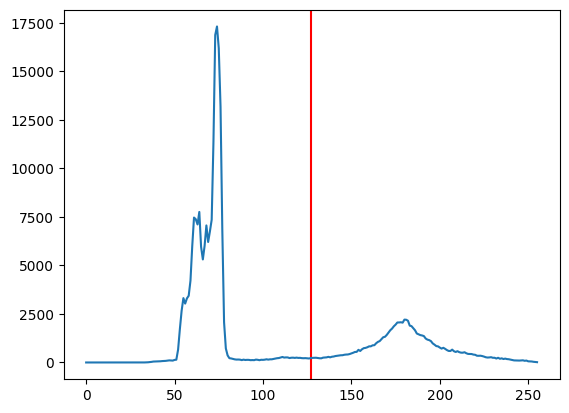

In [31]:
def compute_otsu_threshold(histogram):
    # Anzahl Grauwerte (Histogrammlänge)
    histogram_len = len(histogram)

    # Anzahl der Pixel ermitteln (N)
    pixel_amount = 0
    for i in range(histogram_len):
        pixel_amount += histogram[i]
    
    # optimalen Threshold ermitteln
    best_threshold = 0
    best_variance = np.inf
    for threshold in range(histogram_len):
        
        # Anzahl der Pixel ermitteln, die auf der helleren Seite vom Threshold sind (N_H)
        pixels_brighter_threshold = 0
        for i in range(threshold):
            pixels_brighter_threshold += histogram[i]

        # Anzahl der Pixel ermitteln, die auf der dunkleren Seite vom Threshold sind (N_V)
        pixels_darker_threshold = 0
        for i in range(threshold, histogram_len):
            pixels_darker_threshold += histogram[i]

        # Gewicht von beiden Seiten ermitteln (W_H und W_V)
        weight_brightside = pixels_brighter_threshold / pixel_amount
        weight_darkside = pixels_darker_threshold / pixel_amount

        # Varianz von der hellen Seite berechnen
        variance_bright = calculate_variance_bright(pixels_brighter_threshold, histogram, threshold)
        
        # Varianz von der dunklen Seite berechnen
        variance_dark = calculate_variance_dark(pixels_darker_threshold, histogram, threshold)

        # Gewichtete Varianz berechnen
        weighted_variance = weight_brightside * variance_bright + weight_darkside * variance_dark

        # Prüfen ob dieser Throshold besser ist, als der bisher beste Threshold
        if weighted_variance < best_variance:
            best_variance = weighted_variance
            best_threshold = threshold
    
    print("done")
    return best_threshold



def calculate_variance_bright(pixels, histogram, threshold):
    # Fallunterscheidung: Es darf nicht durch 0 geteilt werden
    if pixels == 0:
        variance = np.inf
    else:
        some_sum = 0
        for i in range(threshold):
            some_sum += i * histogram[i]
        u = 1 / pixels * some_sum

        some_sum = 0
        for i in range(threshold):
            some_sum += (i - u) * (i - u) * histogram[i]
        variance = 1 / pixels * some_sum
    return variance

def calculate_variance_dark(pixels, histogram, threshold):
    # Fallunterscheidung: Es darf nicht durch 0 geteilt werden
    if pixels == 0:
        variance = np.inf
    else:
        some_sum = 0
        for i in range(threshold, len(histogram)):
            some_sum += i * histogram[i]
        u = 1 / pixels * some_sum

        some_sum = 0
        for i in range(threshold, len(histogram)):
            some_sum += (i - u) * (i - u) * histogram[i]
        variance = 1 / pixels * some_sum
    return variance

def show_threshold(histogram, threshold):
    plt.axvline(x = threshold, color = 'red')
    plt.plot(histogram)
histogram = create_histogram("coins.bmp")
show_threshold(histogram, compute_otsu_threshold(histogram))

In [32]:
def binarize(image_path):
    
    # Bild einlesen und in numpy-array umwandeln
    image = Image.open(image_path)
    image_array = np.array(image, dtype='uint8')
    
    # Maße des Bildes bestimmen
    height, width = image_array.shape

    # Histogramm berechnen
    histogram = create_histogram(image_path)
    histogram_len = len(histogram)

    # Threshold berechnen
    threshold = compute_otsu_threshold(histogram)
    
    # Bild binarisieren
    binary_image_array = np.zeros_like(image_array)
    for x in range(width):
        for y in range(height):
            if image_array[y][x] < threshold:
                binary_image_array[y][x] = 0
            else:
                binary_image_array[y][x] = histogram_len - 1
    
    return binary_image_array

C:\Users\jalit\AppData\Local\Temp\ipykernel_17460\2209083084.py:36: RuntimeWarning: invalid value encountered in double_scalars
  weighted_variance = weight_brightside * variance_bright + weight_darkside * variance_dark


done


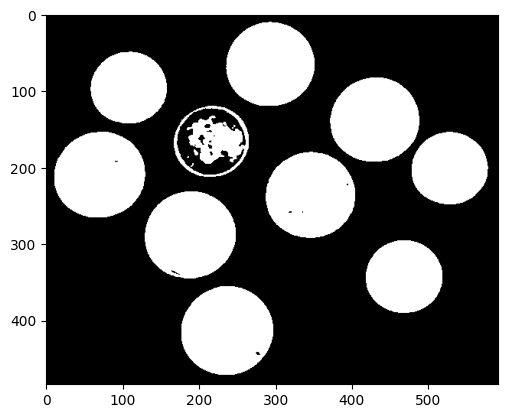

In [33]:
plt.imshow(binarize("coins.bmp"), cmap='gray', vmin=0, vmax=2**8)